In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

AAPL_prices = pd.read_csv("../data/raw/yf_prices/AAPL.csv")
AMZN_prices = pd.read_csv("../data/raw/yf_prices/AMZN.csv")
BA_prices = pd.read_csv("../data/raw/yf_prices/BA.csv")
CAT_prices = pd.read_csv("../data/raw/yf_prices/CAT.csv")
CVX_prices = pd.read_csv("../data/raw/yf_prices/CVX.csv")
GS_prices = pd.read_csv("../data/raw/yf_prices/GS.csv")
JNJ_prices = pd.read_csv("../data/raw/yf_prices/JNJ.csv")
JPM_prices = pd.read_csv("../data/raw/yf_prices/JPM.csv")
MSFT_prices = pd.read_csv("../data/raw/yf_prices/MSFT.csv")
NEE_prices = pd.read_csv("../data/raw/yf_prices/NEE.csv")
NVDA_prices = pd.read_csv("../data/raw/yf_prices/NVDA.csv")
PFE_prices = pd.read_csv("../data/raw/yf_prices/PFE.csv")
TSLA_prices = pd.read_csv("../data/raw/yf_prices/TSLA.csv")
XOM_prices = pd.read_csv("../data/raw/yf_prices/XOM.csv")

In [51]:
def clean_prices_df(df):
    df = df.copy()
    df.rename(columns={"Price": "Date"}, inplace=True)
    df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
    df = df.dropna(subset=["Close"]).reset_index(drop=True)
    for col in ["High", "Low", "Open", "Volume"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    return df

In [52]:
AAPL_prices = clean_prices_df(AAPL_prices)
AMZN_prices = clean_prices_df(AMZN_prices)
BA_prices = clean_prices_df(BA_prices)
CAT_prices = clean_prices_df(CAT_prices)
CVX_prices = clean_prices_df(CVX_prices)
GS_prices = clean_prices_df(GS_prices)
JNJ_prices = clean_prices_df(JNJ_prices)
JPM_prices = clean_prices_df(JPM_prices)
MSFT_prices = clean_prices_df(MSFT_prices)
NEE_prices = clean_prices_df(NEE_prices)
NVDA_prices = clean_prices_df(NVDA_prices)
PFE_prices = clean_prices_df(PFE_prices)
TSLA_prices = clean_prices_df(TSLA_prices)
XOM_prices = clean_prices_df(XOM_prices)

In [53]:
def feature_engineer_prices_df(df):
    df = df.copy()

    # --- Basic price change features ---
    df["Return_1d"] = df["Close"].pct_change()
    df["Return_7d"] = df["Close"].pct_change(7)

    # --- Moving averages ---
    df["MA_7"] = df["Close"].rolling(window=7).mean()
    df["MA_14"] = df["Close"].rolling(window=14).mean()
    df["MA_30"] = df["Close"].rolling(window=30).mean()

    # --- Volatility ---
    df["Volatility_7d"] = df["Return_1d"].rolling(window=7).std()
    df["Volatility_14d"] = df["Return_1d"].rolling(window=14).std()

    # --- Volume features ---
    df["Volume_MA_7"] = df["Volume"].rolling(window=7).mean()
    df["Volume_Change_1d"] = df["Volume"].pct_change()

    # --- Lag features (previous close prices) ---
    df["Close_Lag_1"] = df["Close"].shift(1)
    df["Close_Lag_2"] = df["Close"].shift(2)
    df["Close_Lag_3"] = df["Close"].shift(3)
    df["Close_Lag_5"] = df["Close"].shift(5)
    df["Close_Lag_7"] = df["Close"].shift(7)
    df["Close_Lag_14"] = df["Close"].shift(14)
    df["Close_Lag_21"] = df["Close"].shift(21)

    # --- RSI (Relative Strength Index) ---
    delta = df["Close"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df["RSI_14"] = 100 - (100 / (1 + rs))

    # --- MACD (Moving Average Convergence Divergence) ---
    # Fast and Slow Exponential Moving Averages
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()

    # MACD Line
    df["MACD"] = df["EMA_12"] - df["EMA_26"]

    # Signal Line (9-day EMA of MACD)
    df["MACD_Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # interaction features
    df["Price_vs_MA30"] = df["Close"] / df["MA_30"]
    df["Vol_x_Return"] = df["Volume_Change_1d"] * df["Return_1d"]

    # Bollinger Bands
    df["MA_20"] = df["Close"].rolling(window=20).mean()
    df["Std_Dev_20"] = df["Close"].rolling(window=20).std()
    df["Bollinger_Upper"] = df["MA_20"] + (2 * df["Std_Dev_20"])
    df["Bollinger_Lower"] = df["MA_20"] - (2 * df["Std_Dev_20"])
    df["Price_vs_Bollinger"] = (df["Close"] - df["MA_20"]) / (
        2 * df["Std_Dev_20"]
    )  # Normalize position within bands

    # date features
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["Month"] = df["Date"].dt.month
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)
    df["Year"] = df["Date"].dt.year

    # range features
    df["Price_Range_HL"] = df["High"] - df["Low"]
    df["Price_Change_OC"] = df["Close"] - df["Open"]

    # --- Drop very early rows that have NaNs due to rolling windows ---
    df = df.dropna().reset_index(drop=True)

    return df

In [54]:
def prepare_lstm_data(df, target_col="Close", target_days=7, window_size=30):
    df = df.copy()
    
    # Target and base price setup
    df["Prediction_Base_Price"] = df[target_col].shift(target_days)
    df["Target_Return"] = df[target_col].pct_change(periods=target_days).shift(-target_days)
    df.dropna(subset=["Target_Return", "Prediction_Base_Price", target_col], inplace=True)

    # Scale the 'Close' prices
    scaler = MinMaxScaler()
    df["Close_scaled"] = scaler.fit_transform(df[[target_col]])

    # Create sequences
    data = df["Close_scaled"].values
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(df["Target_Return"].values[i + window_size])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D input

    # Align base prices and dates
    df = df.iloc[window_size:]  # Align to match sequence start
    base_prices = df["Prediction_Base_Price"].values
    dates = df["Date"].values

    # Train/test split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    base_prices_train, base_prices_test = base_prices[:split_idx], base_prices[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]

    return X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler


In [55]:
def create_model(units=50, dropout_rate=0.2, learning_rate=0.001, input_shape=(30, 1)):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error")
    return model

In [56]:
def cross_validate_lstm(X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    val_losses = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"\nFold {fold+1}")
        
        X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
        y_train_cv, y_val_cv = y_train[train_idx], y_train[val_idx]

        model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
        early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        
        history = model.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=50,
            batch_size=32,
            callbacks=[early_stop],
            verbose=1
        )
        
        val_loss = min(history.history["val_loss"])
        val_losses.append(val_loss)
        print(f"Fold {fold+1} Validation Loss: {val_loss:.4f}")
    
    return val_losses

In [57]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, stock_name): 
    print(f"\nTraining LSTM model for {stock_name}...")
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = model.predict(X_test).flatten()
    predicted_prices = base_prices_test * (1 + y_pred)
    actual_prices = base_prices_test * (1 + y_test)

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(dates_test, actual_prices, label="Actual Prices")
    plt.plot(dates_test, predicted_prices, label="Predicted Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{stock_name} Price Prediction")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # RMSE on predicted percentage changes
    rmse_percentage_change = rmse(y_test, y_pred)
    print(f"RMSE on Percentage Change: {rmse_percentage_change:.4f}")

    # RMSE on predicted prices
    rmse_prices = rmse(actual_prices, predicted_prices)
    print(f"RMSE on Prices: {rmse_prices:.4f}")

    return model


Training LSTM model for Apple...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024 - val_loss: 0.0018
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


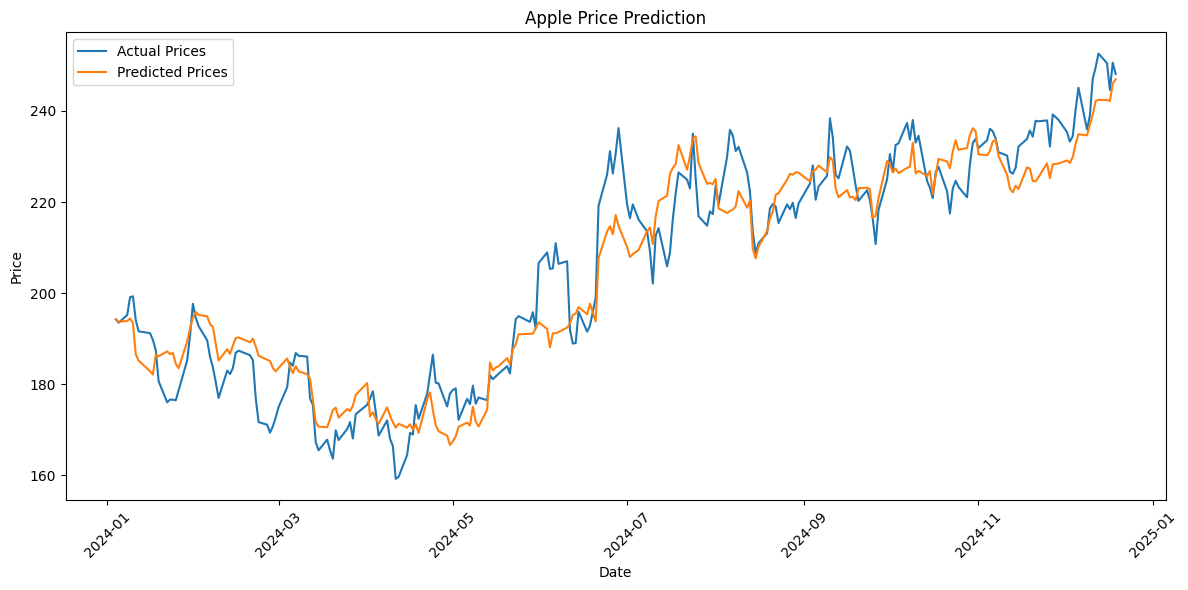

RMSE on Percentage Change: 0.0374
RMSE on Prices: 7.4902


In [58]:
# Apple LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(AAPL_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Apple")



Training LSTM model for Amazon...


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - val_loss: 0.0023
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


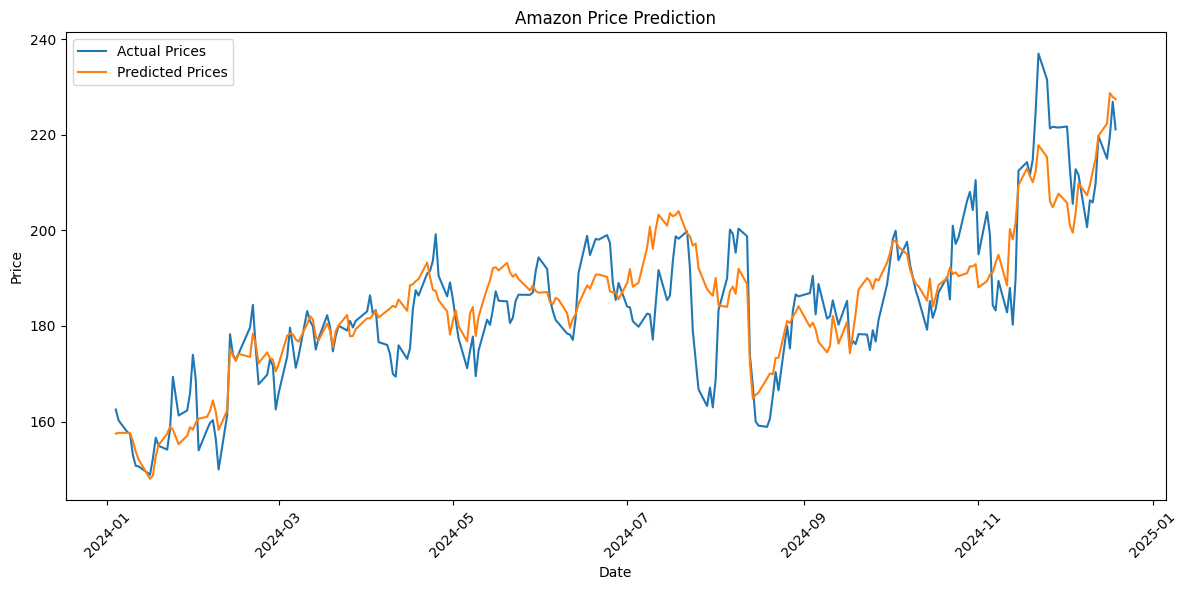

RMSE on Percentage Change: 0.0447
RMSE on Prices: 8.3382


In [59]:
# AMZN LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(AMZN_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Amazon")




Training LSTM model for Boeing...


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0112 - val_loss: 0.0026
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0089 - val_loss: 0.0038
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0103 - val_loss: 0.0033
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0096 - val_loss: 0.0035
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0079 - val_loss: 0.0033
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


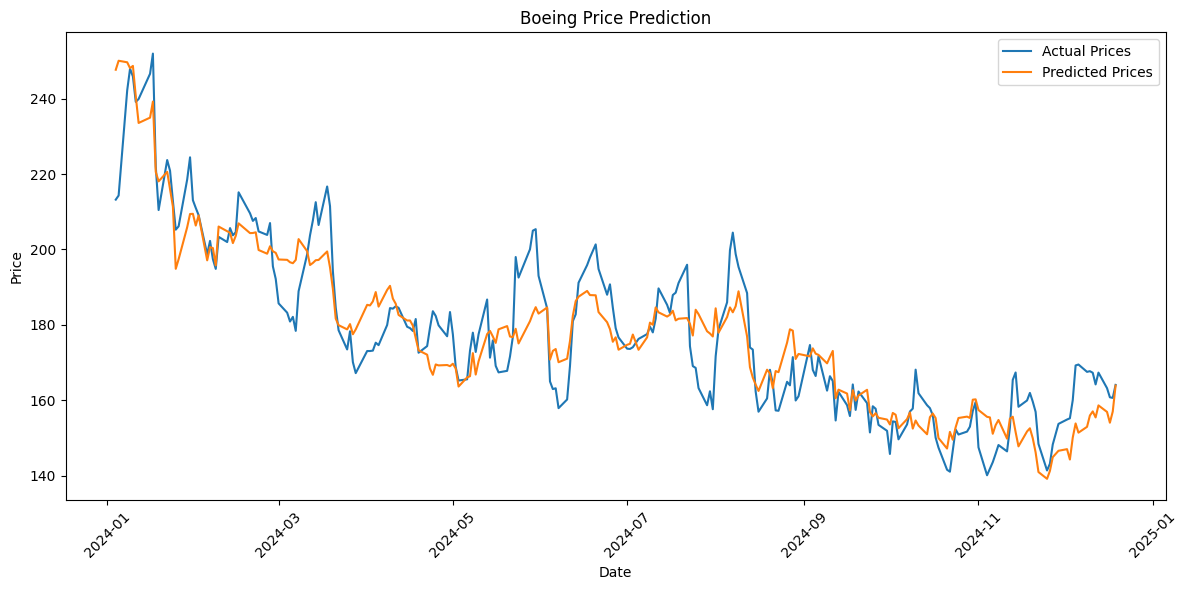

RMSE on Percentage Change: 0.0509
RMSE on Prices: 9.3156


In [60]:
# BA LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(BA_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Boeing")




Training LSTM model for Caterpillar...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0076 - val_loss: 0.0024
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 0.0025
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033 - val_loss: 0.0030
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


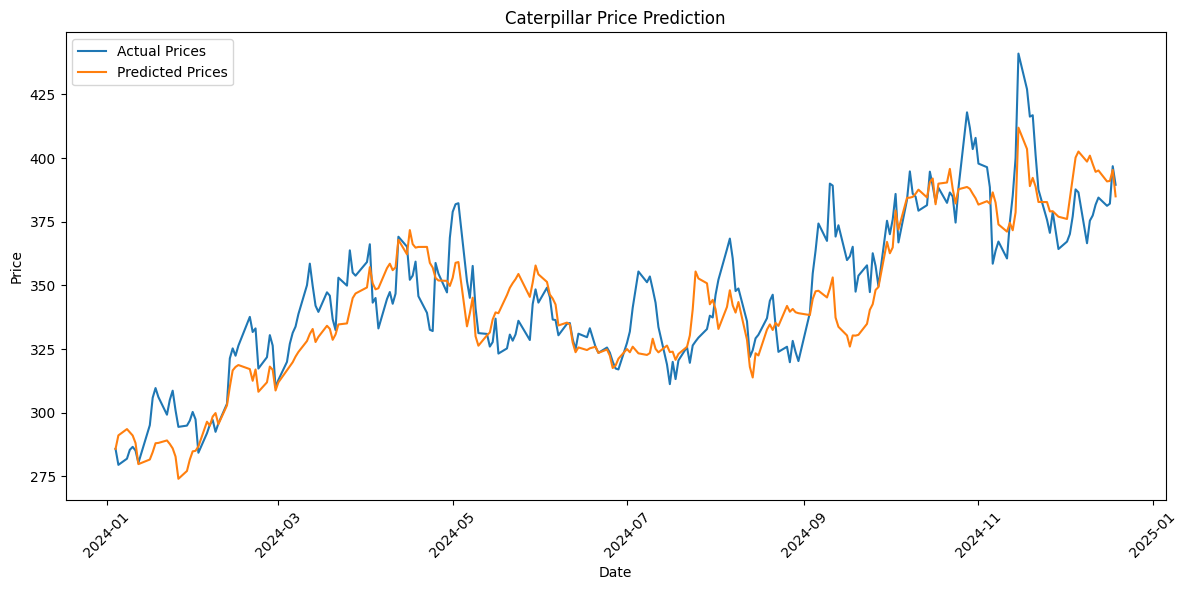

RMSE on Percentage Change: 0.0438
RMSE on Prices: 15.0376


In [61]:
# CAT LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(CAT_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Caterpillar")




Training LSTM model for Chevron...


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0037 - val_loss: 0.0011
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0011
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


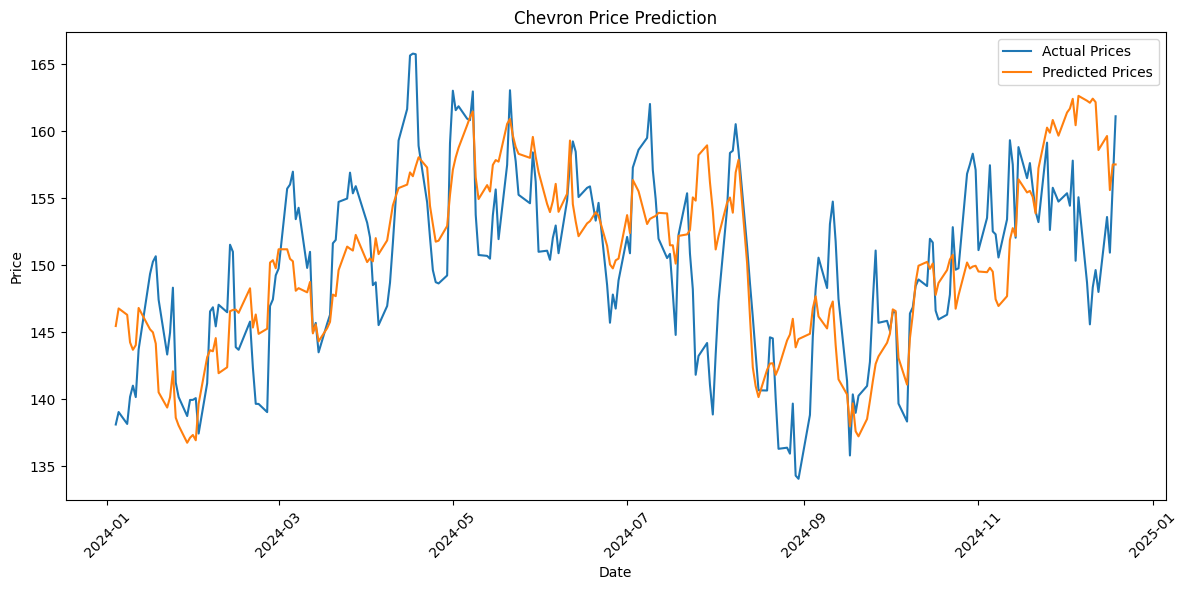

RMSE on Percentage Change: 0.0333
RMSE on Prices: 5.0595


In [62]:
# CVX LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(CVX_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Chevron")




Training LSTM model for Goldman Sachs...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0032 - val_loss: 0.0025
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


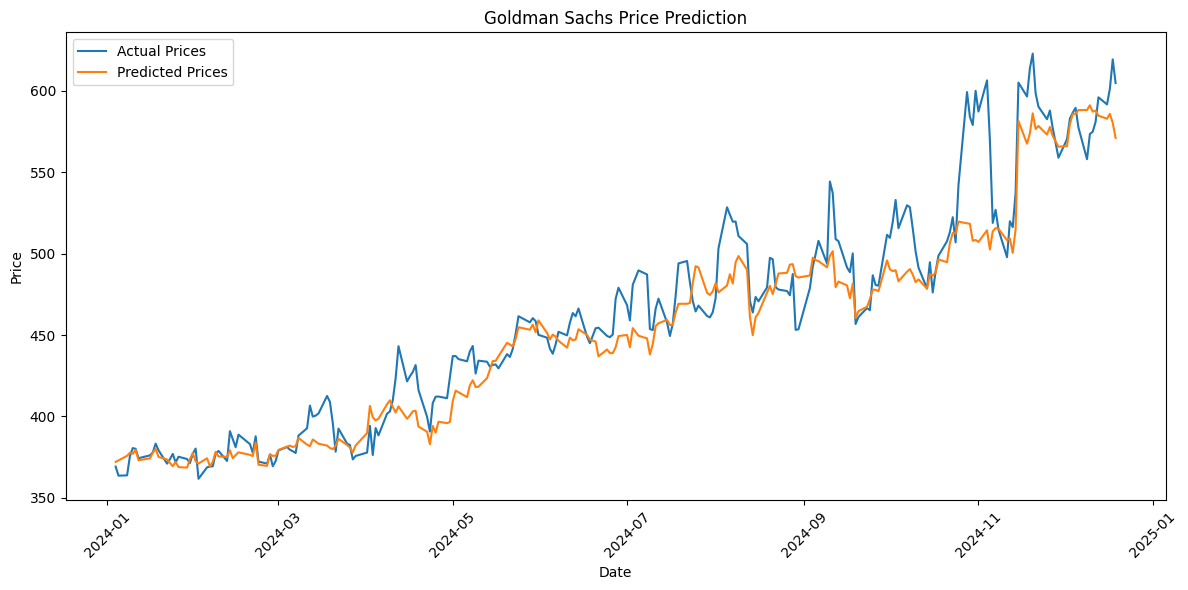

RMSE on Percentage Change: 0.0438
RMSE on Prices: 21.2826


In [63]:
# GS LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(GS_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Goldman Sachs")




Training LSTM model for Johnson & Johnson...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0041 - val_loss: 9.6479e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0020 - val_loss: 6.1351e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0015 - val_loss: 5.6871e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 5.6088e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0010 - val_loss: 5.6580e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0012 - val_loss: 5.6047e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 7.1379e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 5.5649e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.5226e-04 - val_loss: 6.3644e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0011 - val_loss: 5.9517e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.4330e-04 - val_loss: 5.7671e-04
Epoch 12/50
31/31 ━━━━

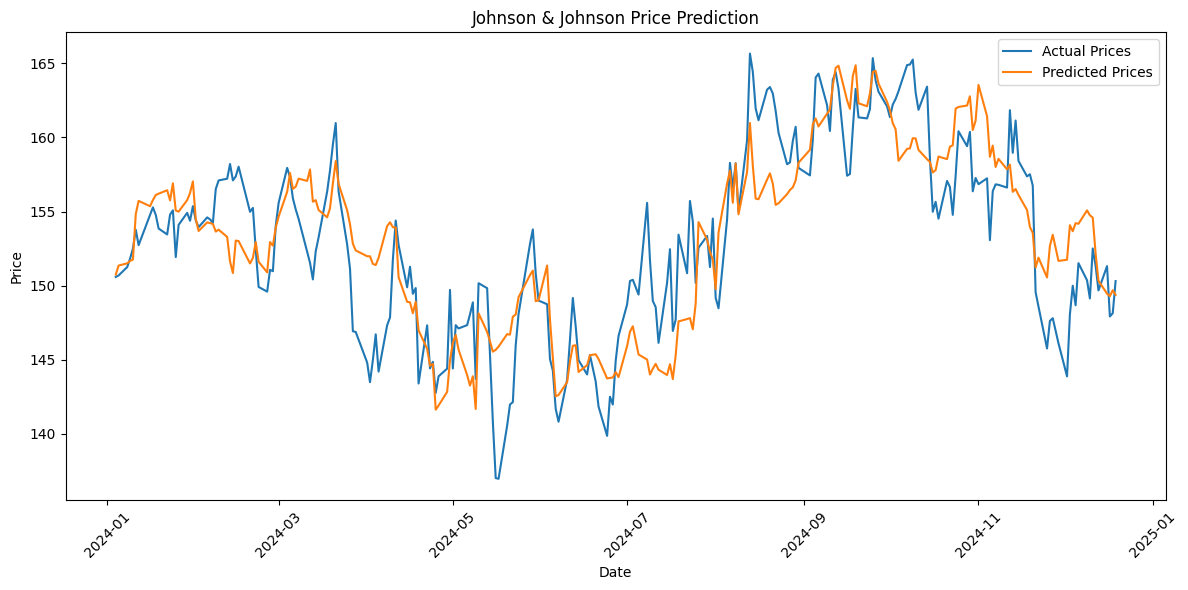

RMSE on Percentage Change: 0.0236
RMSE on Prices: 3.5902


In [64]:
# JNJ LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(JNJ_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Johnson & Johnson")




Training LSTM model for JPMorgan Chase...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 0.0021
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


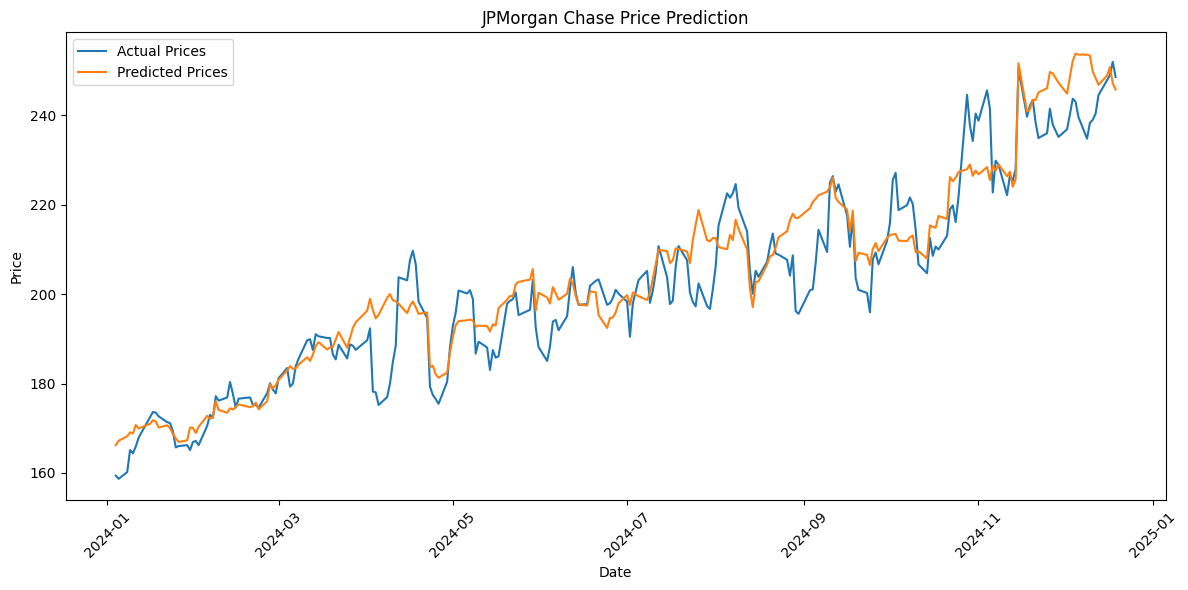

RMSE on Percentage Change: 0.0368
RMSE on Prices: 7.6133


In [65]:
# JPM LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(JPM_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "JPMorgan Chase")




Training LSTM model for Microsoft...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0014
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


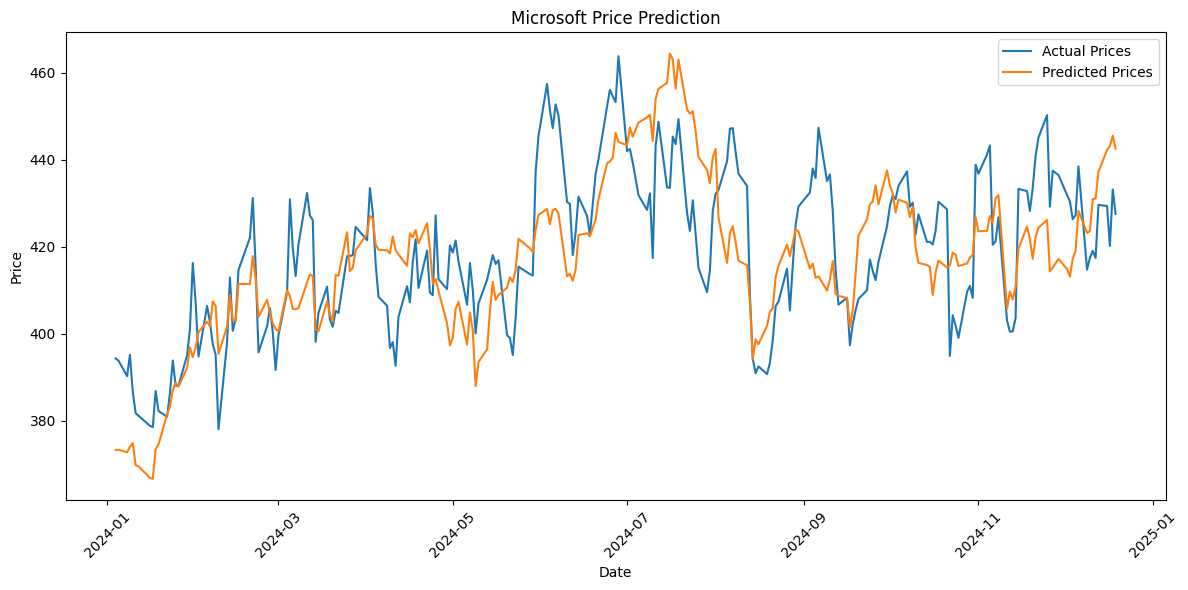

RMSE on Percentage Change: 0.0324
RMSE on Prices: 13.5997


In [66]:
# MSFT LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(MSFT_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Microsoft")




Training LSTM model for NextEra Energy...


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.0017
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


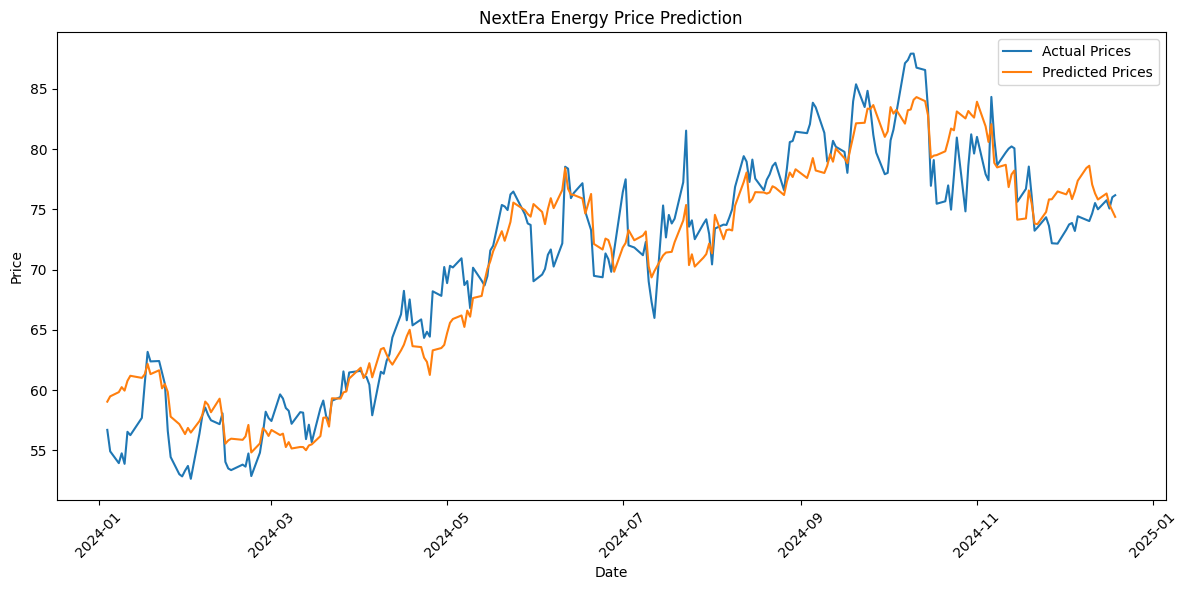

RMSE on Percentage Change: 0.0398
RMSE on Prices: 2.7491


In [67]:
# NEE LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(NEE_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "NextEra Energy")




Training LSTM model for Nvidia...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - val_loss: 0.0176
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0084
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0071 - val_loss: 0.0096
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - val_loss: 0.0099
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0078 - val_loss: 0.0086
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


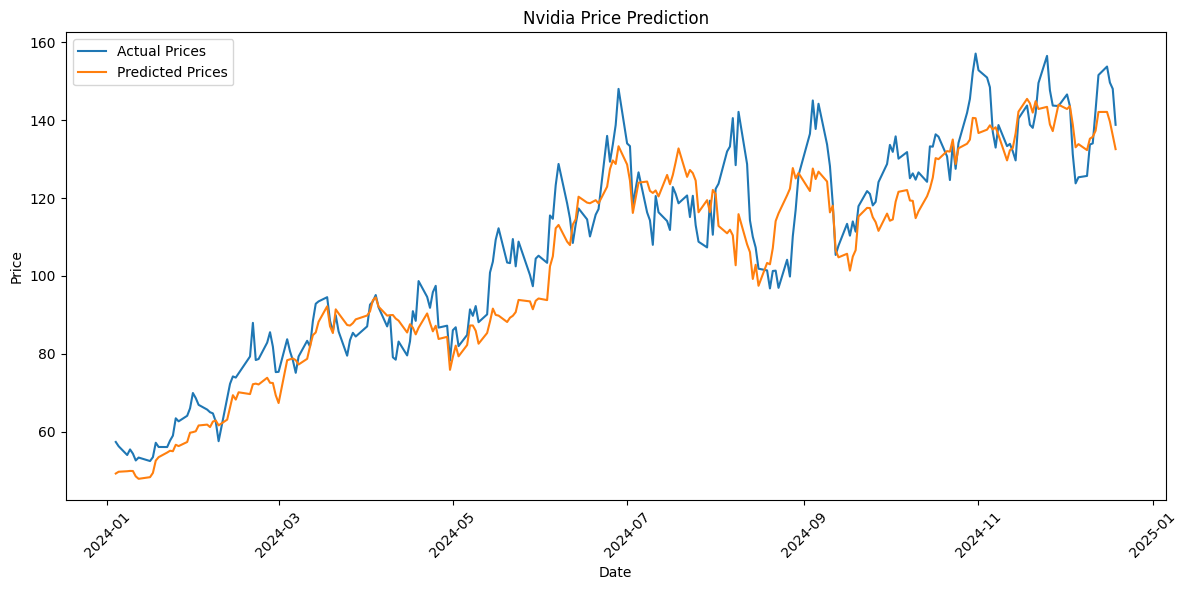

RMSE on Percentage Change: 0.0900
RMSE on Prices: 9.2041


In [68]:
# NVDA LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(NVDA_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Nvidia")




Training LSTM model for Pfizer...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0013
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


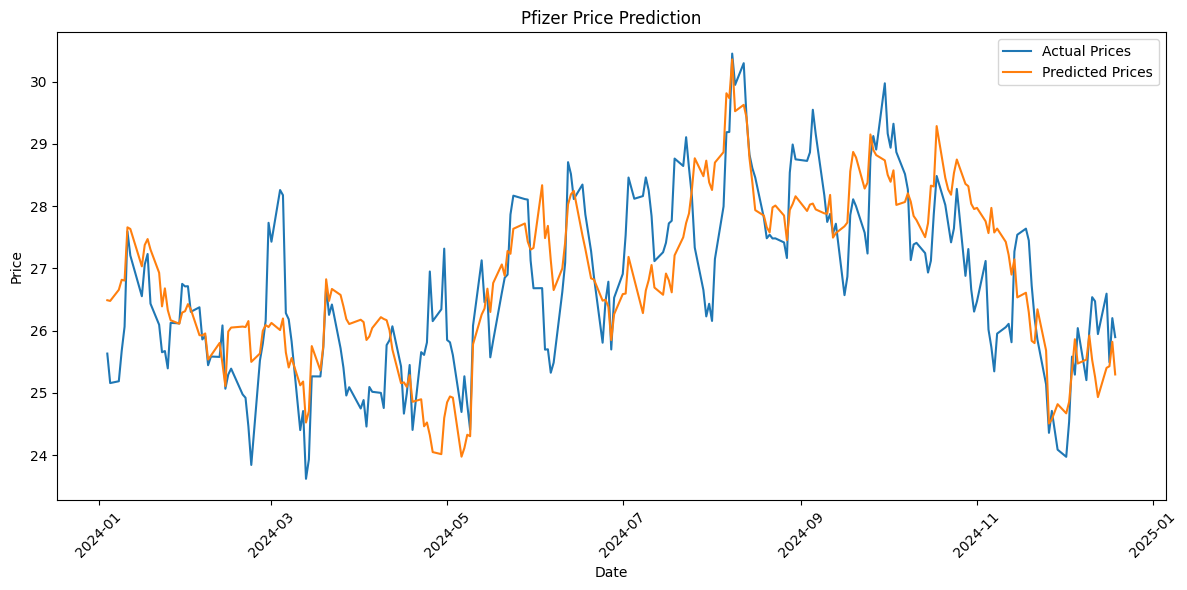

RMSE on Percentage Change: 0.0359
RMSE on Prices: 0.9539


In [69]:
# PFE LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(PFE_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Pfizer")




Training LSTM model for Tesla...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0127 - val_loss: 0.0133
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0143 - val_loss: 0.0134
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0130 - val_loss: 0.0132
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0107 - val_loss: 0.0132
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0126 - val_loss: 0.0132
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0131 - val_l

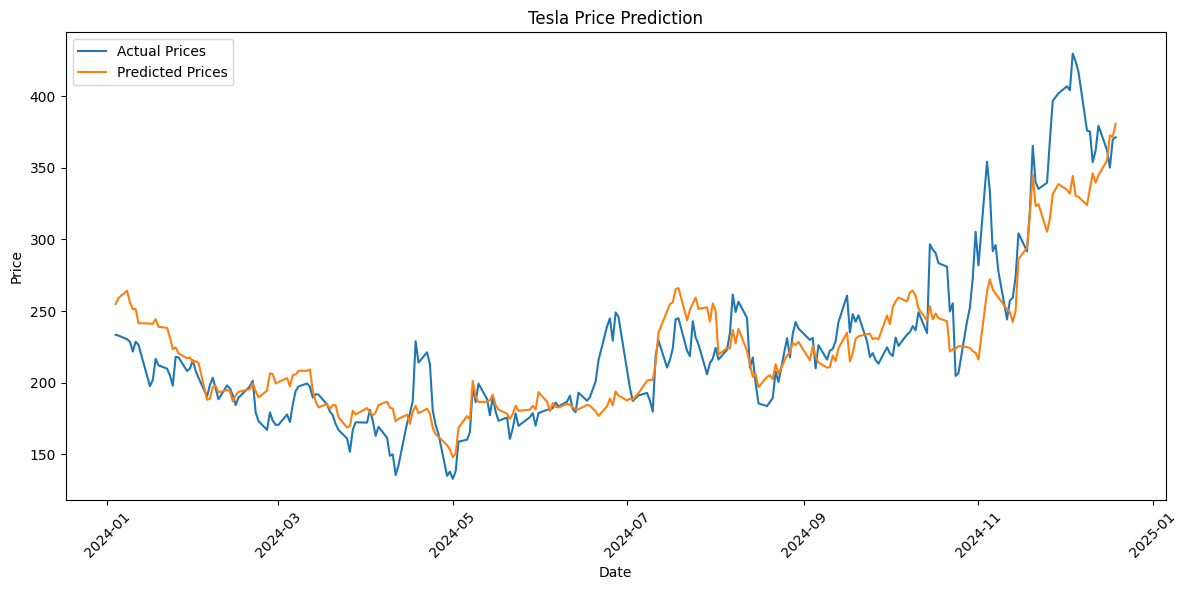

RMSE on Percentage Change: 0.1146
RMSE on Prices: 26.9988


In [70]:
# TSLA LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(TSLA_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Tesla")




Training LSTM model for Exxon Mobil...
Epoch 1/50


/Users/ericquezada/Desktop/Machine Learning/stock-price-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039 - val_loss: 0.0011
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


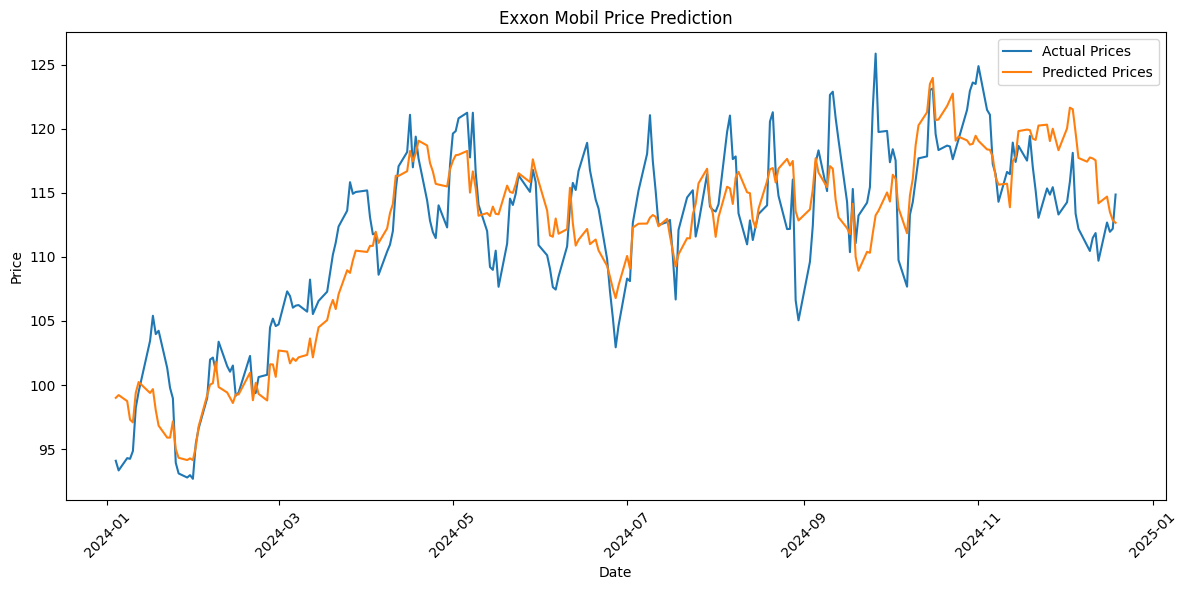

RMSE on Percentage Change: 0.0324
RMSE on Prices: 3.6125


In [71]:
# XOM LSTM Model
X_train, X_test, y_train, y_test, base_prices_test, dates_test, scaler = prepare_lstm_data(XOM_prices)
model = train_lstm_model(X_train, y_train, X_test, y_test, base_prices_test, dates_test, scaler, "Exxon Mobil")

